# Bias Mitigation Analysis - COMPAS

In [1]:
data_name = 'Compas'

In [2]:
# define desired metric for the use case
ACC_METRIC = 'avg_norm_mcc_score'
FAIR_METRIC = 'abs_avg_ppvd_score'

In [3]:
import os
import pandas as pd
import numpy as np
results_all = pd.DataFrame()
dir_path = './{}_results/'.format(data_name)
for file in os.listdir(dir_path):
    print(file)
    result = pd.read_pickle(dir_path+file)
    results_all = pd.concat([results_all, result])

Compas_results_SVM
Compas_results_RF
Compas_results_GB
Compas_results_NB
Compas_results_TabTrans
Compas_results_LR


In [4]:
print(results_all.shape)
results_all.head(2)

(960, 19)


,base_estimator,param,Bias_Mitigation,threshold,avg_acc_score,avg_bacc_score,avg_f1_score,avg_auc_score,avg_mcc_score,avg_norm_mcc_score,avg_spd_score,avg_aod_score,avg_eod_score,avg_ford_score,avg_ppvd_score,avg_(1-consistency_score),avg_gei_score,avg_ti_score,cost
0,SVM,"{'gamma': 'scale', 'kernel': 'rbf'}",None,0.3,0.638374,0.618835,0.728254,0.71922,0.294836,0.647418,0.189346,0.170681,0.236509,0.063433,-0.007808,0.055285,0.091635,0.109257,0.541928
1,SVM,"{'gamma': 'scale', 'kernel': 'rbf'}",None,0.4,0.659187,0.644980,0.728129,0.71922,0.322318,0.661159,0.224587,0.199339,0.261602,0.048607,0.016419,0.050244,0.108839,0.137291,0.563428


In [5]:
import seaborn as sns
accuracy_metrics = ['acc_score', 'bacc_score', 'f1_score', 'auc_score', 'mcc_score','norm_mcc_score']
group_fairness = ['spd_score', 'aod_score', 'eod_score','ford_score','ppvd_score']
individual_fairness = ['(1-consistency_score)','gei_score','ti_score']
fairness_metrics = group_fairness+individual_fairness
avg_accuracy_metrics = ['avg_'+col for col in accuracy_metrics]
avg_fairness_metrics = ['avg_'+col for col in fairness_metrics]

In [6]:
results_all_converted = results_all.copy(deep=True).reset_index(drop=True)
for col in avg_fairness_metrics:
    abs_col_name = 'abs_'+col
    results_all_converted[abs_col_name] = results_all_converted[col].abs()
# round threshold since 0.4 was 0.399999999 
results_all_converted.threshold = round(results_all_converted.threshold,2)
# base estimator invariant in-processing methods shouldn't have any parameter value
results_all_converted.loc[results_all_converted.Bias_Mitigation.isin(['AD','LFR_in']),['param']] = ''

In [7]:
base_invariant = results_all_converted.loc[results_all_converted.Bias_Mitigation.isin(['AD','LFR_in'])]
for base in results_all_converted.base_estimator.unique():
    if results_all_converted[(results_all_converted.base_estimator==base)\
                             &((results_all_converted.Bias_Mitigation=='AD')|(results_all_converted.Bias_Mitigation=='LFR_in'))].shape[0]==0:
        dup = base_invariant.copy()
        dup['base_estimator'] = dup['base_estimator'].replace({'LR':base})
        results_all_converted = pd.concat([results_all_converted, dup])
results_all_converted.head()

,base_estimator,param,Bias_Mitigation,threshold,avg_acc_score,avg_bacc_score,avg_f1_score,avg_auc_score,avg_mcc_score,avg_norm_mcc_score,...,avg_ti_score,cost,abs_avg_spd_score,abs_avg_aod_score,abs_avg_eod_score,abs_avg_ford_score,abs_avg_ppvd_score,abs_avg_(1-consistency_score),abs_avg_gei_score,abs_avg_ti_score
0,SVM,"{'gamma': 'scale', 'kernel': 'rbf'}",None,0.3,0.638374,0.618835,0.728254,0.71922,0.294836,0.647418,...,0.109257,0.541928,0.189346,0.170681,0.236509,0.063433,0.007808,0.055285,0.091635,0.109257
1,SVM,"{'gamma': 'scale', 'kernel': 'rbf'}",None,0.4,0.659187,0.644980,0.728129,0.71922,0.322318,0.661159,...,0.137291,0.563428,0.224587,0.199339,0.261602,0.048607,0.016419,0.050244,0.108839,0.137291
2,SVM,"{'gamma': 'scale', 'kernel': 'rbf'}",None,0.5,0.672195,0.664129,0.718378,0.71922,0.339463,0.669732,...,0.176072,0.602174,0.271906,0.242521,0.302910,0.022286,0.039299,0.054439,0.132440,0.176072
3,SVM,"{'gamma': 'scale', 'kernel': 'rbf'}",None,0.6,0.670407,0.671506,0.679594,0.71922,0.342379,0.671190,...,0.249190,0.634451,0.305641,0.270018,0.288194,0.004983,0.035261,0.060390,0.177543,0.249190
4,SVM,"{'gamma': 'scale', 'kernel': 'rbf'}",None,0.7,0.611870,0.626659,0.528443,0.71922,0.278641,0.639320,...,0.411968,0.595431,0.234751,0.203574,0.174362,0.004531,0.073784,0.069138,0.287560,0.411968


In [8]:
results_all_converted.base_estimator.value_counts()

SVM         200
RF          200
GB          200
NB          200
LR          200
TabTrans    160
Name: base_estimator, dtype: int64

In [9]:
# BEST MODELS
scoring = (ACC_METRIC,FAIR_METRIC,1,1)
w_acc = scoring[2]
w_fair = scoring[3]
acc_cost = 1-results_all_converted[ACC_METRIC]
fair_cost = abs(results_all_converted[FAIR_METRIC])

results_all_converted['cost'] = w_acc*acc_cost + w_fair*fair_cost
best_models = results_all_converted.sort_values(by='cost')[['base_estimator','param','Bias_Mitigation','threshold',
                                                            ACC_METRIC,FAIR_METRIC,'cost']].drop_duplicates(subset='cost').head(10)
best_models.rename({ACC_METRIC: 'Norm. MCC',
                    FAIR_METRIC: 'Abs. '+FAIR_METRIC.removeprefix('abs_').removeprefix('avg_').removesuffix('_score').upper()}, axis=1, inplace=True)
best_models.columns = [col if best_models.columns.get_loc(col) in [4,5]\
                       else col.replace('_',' ').title() for col in best_models.columns] 
f = {best_models.columns[i]:'{:.4f}' for i in range(-3,0)}
f.update({'Threshold':'{:.1f}'})
styled_best_models = best_models.style.format(f).hide(axis="index")
print(styled_best_models.to_latex(hrules=True, label="table:results_{}".format(data_name),
                                  caption="Top 5 Models for {}".format(data_name)).replace('_','\_'))
display(styled_best_models)

\begin{table}
\caption{Top 5 Models for Compas}
\label{table:results\_Compas}
\begin{tabular}{lllrrrr}
\toprule
Base Estimator & Param & Bias Mitigation & Threshold & Norm. MCC & Abs. PPVD & Cost \\
\midrule
GB & {'criterion': 'friedman\_mse', 'max\_depth': 8, 'n\_estimators': 10} & RW+ROC & 0.5 & 0.6506 & 0.0019 & 0.3512 \\
LR & {'C': 1, 'penalty': 'l2', 'solver': 'saga'} & None & 0.4 & 0.6539 & 0.0054 & 0.3515 \\
LR & {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'} & None & 0.4 & 0.6541 & 0.0056 & 0.3515 \\
LR & {'C': 10, 'penalty': 'l2', 'solver': 'saga'} & ROC & 0.4 & 0.6543 & 0.0058 & 0.3516 \\
SVM & {'gamma': 'scale', 'kernel': 'rbf'} & RW+ROC & 0.5 & 0.6711 & 0.0241 & 0.3530 \\
LR & {'C': 10, 'penalty': 'l2', 'solver': 'saga'} & CEO & 0.4 & 0.6497 & 0.0037 & 0.3540 \\
LR & {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'} & CEO & 0.4 & 0.6495 & 0.0039 & 0.3544 \\
SVM & {'gamma': 'scale', 'kernel': 'poly'} & CEO & 0.5 & 0.6470 & 0.0015 & 0.3545 \\
LR & {'C': 1, 'penalty': 'l2',

Base Estimator,Param,Bias Mitigation,Threshold,Norm. MCC,Abs. PPVD,Cost
GB,"{'criterion': 'friedman_mse', 'max_depth': 8, 'n_estimators': 10}",RW+ROC,0.5,0.6506,0.0019,0.3512
LR,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",None,0.4,0.6539,0.0054,0.3515
LR,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",None,0.4,0.6541,0.0056,0.3515
LR,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",ROC,0.4,0.6543,0.0058,0.3516
SVM,"{'gamma': 'scale', 'kernel': 'rbf'}",RW+ROC,0.5,0.6711,0.0241,0.3530
LR,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",CEO,0.4,0.6497,0.0037,0.3540
LR,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",CEO,0.4,0.6495,0.0039,0.3544
SVM,"{'gamma': 'scale', 'kernel': 'poly'}",CEO,0.5,0.6470,0.0015,0.3545
LR,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",CEO,0.4,0.6493,0.0041,0.3548
SVM,"{'gamma': 'scale', 'kernel': 'rbf'}",ROC,0.4,0.6612,0.0164,0.3553


## Analysis like in Chen et al. (2023)

In [10]:
diff_dict = {}
for base in results_all_converted.base_estimator.unique():
    None_table = results_all_converted[(results_all_converted.base_estimator==base)&
                                       (results_all_converted.Bias_Mitigation=='None')].reset_index(drop=True)
    diff_dict[base] = {}
    for BM in results_all_converted[results_all_converted.base_estimator==base].Bias_Mitigation.unique():
        if BM == 'None': pass
        else: 
            # print(BM)
            BM_subtable = results_all_converted[(results_all_converted.base_estimator==base)&
                                                (results_all_converted.Bias_Mitigation==BM)].reset_index(drop=True)
            diff_table = BM_subtable.iloc[:,:4]
            diff_table = pd.concat([diff_table,BM_subtable.iloc[:,4:].subtract(None_table.iloc[:,4:])], axis=1)
            diff_dict[base][BM] = diff_table

In [11]:
df = pd.DataFrame()
for base in diff_dict.keys():
    sub_df = pd.concat(diff_dict[base])
    df = pd.concat([df, pd.concat(diff_dict[base])])
df

base_estimator                                         param  \
RW     0             SVM           {'gamma': 'scale', 'kernel': 'rbf'}   
       1             SVM           {'gamma': 'scale', 'kernel': 'rbf'}   
       2             SVM           {'gamma': 'scale', 'kernel': 'rbf'}   
       3             SVM           {'gamma': 'scale', 'kernel': 'rbf'}   
       4             SVM           {'gamma': 'scale', 'kernel': 'rbf'}   
...                  ...                                           ...   
RW+CEO 15             LR  {'C': 10, 'penalty': 'l2', 'solver': 'saga'}   
       16             LR  {'C': 10, 'penalty': 'l2', 'solver': 'saga'}   
       17             LR  {'C': 10, 'penalty': 'l2', 'solver': 'saga'}   
       18             LR  {'C': 10, 'penalty': 'l2', 'solver': 'saga'}   
       19             LR  {'C': 10, 'penalty': 'l2', 'solver': 'saga'}   

          Bias_Mitigation  threshold  avg_acc_score  avg_bacc_score  \
RW     0               RW        0.3      -0.007642       -0.008526   
       1               RW        0.4      -0.006341       -0.006534   
       2               RW        0.5      -0.004065       -0.004676   
       3               RW        0.6      -0.006829       -0.007457   
       4               RW        0.7      -0.012195       -0.010048   
...                   ...        ...            ...             ...   
RW+CEO 15          RW+CEO        0.3      -0.009268       -0.010425   
       16          RW+CEO        0.4      -0.022927       -0.024496   
       17          RW+CEO        0.5      -0.030569       -0.031711   
       18          RW+CEO        0.6      -0.005854       -0.006616   
       19          RW+CEO        0.7      -0.012358       -0.010713   

           avg_f1_score  avg_auc_score  avg_mcc_score  avg_norm_mcc_score  \
RW     0      -0.003193      -0.003448      -0.014062           -0.007031   
       1      -0.004478      -0.003448      -0.013968           -0.006984   
       2      -0.001334      -0.003448      -0.008213           -0.004106   
       3      -0.003964      -0.003448      -0.014829           -0.007414   
       4      -0.035064      -0.003448      -0.012571           -0.006285   
...                 ...            ...            ...                 ...   
RW+CEO 15     -0.003211      -0.019790      -0.019455           -0.009727   
       16     -0.012659      -0.019790      -0.050299           -0.025149   
       17     -0.023981      -0.019790      -0.061204           -0.030602   
       18     -0.002778      -0.019790      -0.014849           -0.007425   
       19     -0.038803      -0.019790      -0.015383           -0.007692   

           ...  avg_ti_score      cost  abs_avg_spd_score  abs_avg_aod_score  \
RW     0   ...     -0.002249  0.050490          -0.098916          -0.103448   
       1   ...      0.002410  0.067582          -0.103058          -0.106582   
       2   ...     -0.002000  0.072669          -0.174605          -0.179970   
       3   ...      0.000224  0.103980          -0.234360          -0.234948   
       4   ...      0.030488  0.060821          -0.197330          -0.192602   
...        ...           ...       ...                ...                ...   
RW+CEO 15  ...     -0.003703 -0.003795          -0.076740          -0.081554   
       16  ...      0.001335  0.147810          -0.147136          -0.143841   
       17  ...      0.012367  0.148928          -0.242744          -0.215720   
       18  ...     -0.000934  0.079457          -0.177651          -0.172280   
       19  ...      0.028508  0.047696          -0.156310          -0.150758   

           abs_avg_eod_score  abs_avg_ford_score  abs_avg_ppvd_score  \
RW     0           -0.145679            0.033215            0.043459   
       1           -0.137684            0.032771            0.060599   
       2           -0.213016            0.054757            0.068563   
       3           -0.224854            0.060460            0.096566   
       4           -0.

In [12]:
(df.iloc[:,4:10]>0).sum()/df.shape[0]

avg_acc_score         0.268269
avg_bacc_score        0.271154
avg_f1_score          0.286538
avg_auc_score         0.267308
avg_mcc_score         0.277885
avg_norm_mcc_score    0.277885
dtype: float64

In [13]:
(df[df.Bias_Mitigation=='RW'].avg_norm_mcc_score>0).value_counts(normalize=True)

False    0.7
True     0.3
Name: avg_norm_mcc_score, dtype: float64

### Accuracy Behavior After Bias Mitigations

In [14]:
from analysis_utils import *
%matplotlib inline

,avg_acc_score,avg_bacc_score,avg_f1_score,avg_auc_score,avg_mcc_score,avg_norm_mcc_score
noorincrease,33,34,42,17,32,32
small,0,0,0,7,0,0
medium,3,1,4,2,1,1
large,16,17,6,26,19,19


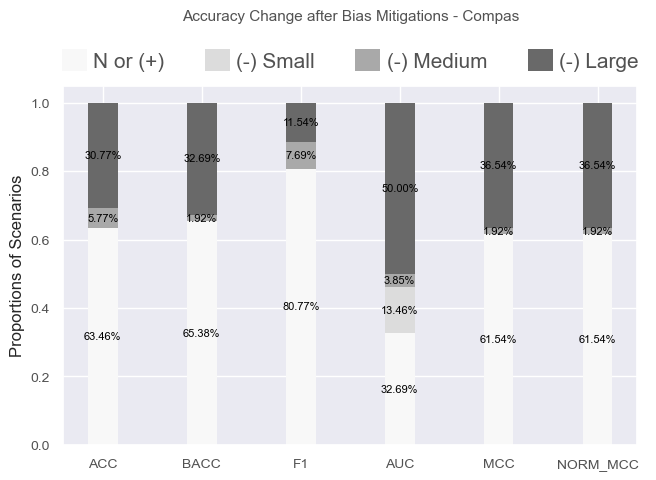

In [15]:
diff_degree = behaviour_analysis(data=results_all_converted, metric_list=avg_accuracy_metrics)
display(pd.DataFrame(diff_degree))
plot_behaviour_analysis(diff_degree, data_name, caption='Accuracy Change after Bias Mitigations - {}', figsize=(8, 6))

### Accuracy Behavior After Bias Mitigations per BM

,RW,LFR_pre,EGR,ROC,CEO,RW+ROC,RW+CEO,LFR_in,AD
noorincrease,6,0,2,6,4,6,2,0,6
small,0,0,0,0,0,0,0,0,0
medium,0,0,0,0,0,0,1,0,0
large,0,5,3,0,2,0,3,6,0


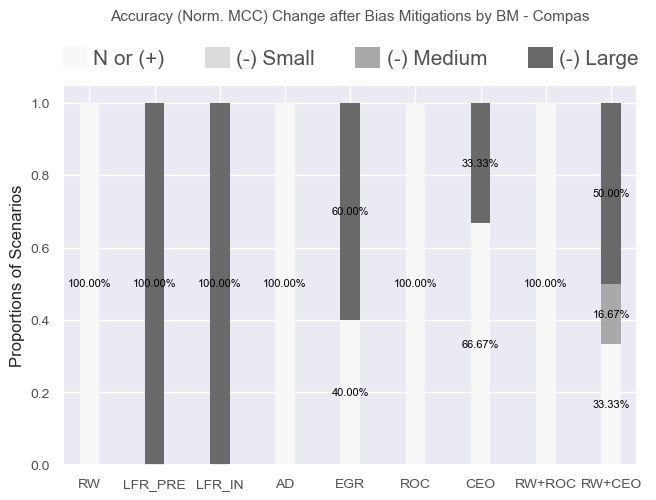

In [16]:
diff_degree = behaviour_analysis(data=results_all_converted, metric_list=[ACC_METRIC], category='bm')
display(pd.DataFrame(diff_degree))
plot_behaviour_analysis(diff_degree, data_name, category='bm', 
                        caption='Accuracy (Norm. MCC) Change after Bias Mitigations by BM - {}', figsize=(8, 6))

### Accuracy Behavior After Bias Mitigations per base

,SVM,RF,GB,NB,TabTrans,LR
noorincrease,6,5,6,4,6,5
small,0,0,0,0,0,0
medium,0,0,1,0,0,0
large,3,4,2,5,1,4


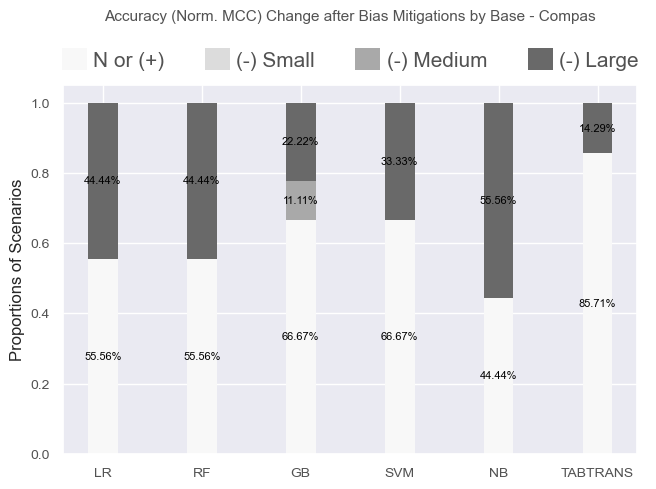

In [17]:
diff_degree = behaviour_analysis(data=results_all_converted, metric_list=[ACC_METRIC], category='base')
display(pd.DataFrame(diff_degree))
plot_behaviour_analysis(diff_degree, data_name, category='base', 
                        caption='Accuracy (Norm. MCC) Change after Bias Mitigations by Base - {}', figsize=(8, 6))

### Fairness Behavior After Bias Mitigations

,abs_avg_spd_score,abs_avg_aod_score,abs_avg_eod_score,abs_avg_ford_score,abs_avg_ppvd_score,abs_avg_(1-consistency_score),abs_avg_gei_score,abs_avg_ti_score
noorincrease,23,23,22,51,47,38,52,52
small,2,2,2,0,1,0,0,0
medium,2,3,2,1,1,0,0,0
large,25,24,26,0,3,14,0,0


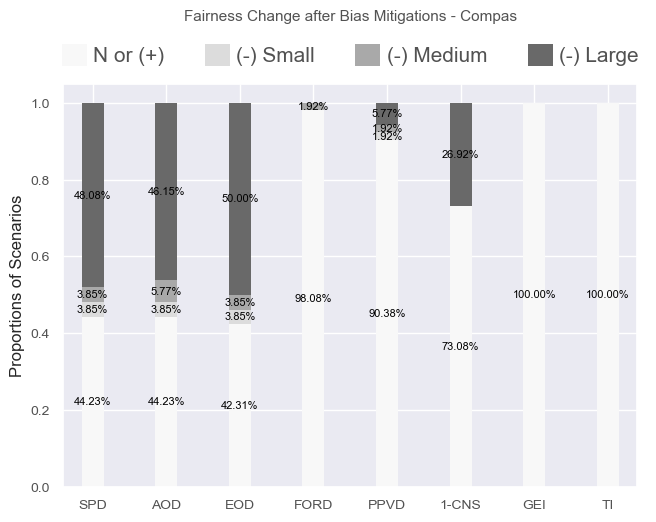

In [18]:
abs_avg_fairness_metrics = ['abs_'+ele for ele in avg_fairness_metrics]
diff_degree = behaviour_analysis(data=results_all_converted, metric_list=abs_avg_fairness_metrics)
display(pd.DataFrame(diff_degree))
plot_behaviour_analysis(diff_degree, data_name, caption='Fairness Change after Bias Mitigations - {}', figsize=(8, 6))

### Fairness Behavior After Bias Mitigations per BM

,RW,LFR_pre,EGR,ROC,CEO,RW+ROC,RW+CEO,LFR_in,AD
noorincrease,6,4,5,6,5,6,6,3,6
small,0,1,0,0,0,0,0,0,0
medium,0,0,0,0,0,0,0,1,0
large,0,0,0,0,1,0,0,2,0


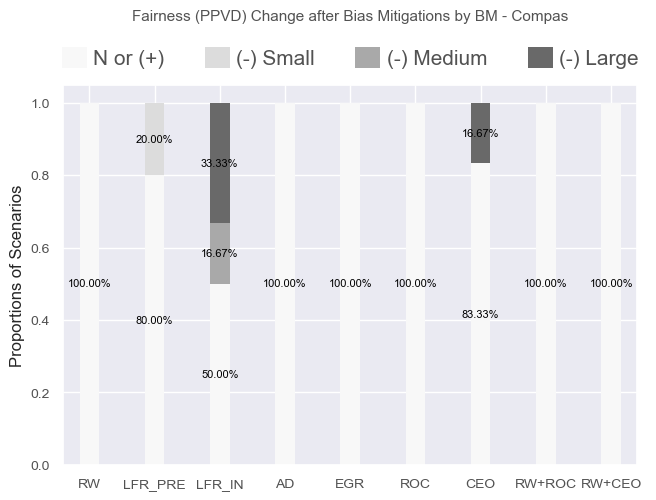

In [19]:
abs_avg_fairness_metrics = ['abs_'+ele for ele in avg_fairness_metrics]
diff_degree = behaviour_analysis(data=results_all_converted, metric_list=[FAIR_METRIC], category='bm')
display(pd.DataFrame(diff_degree))
plot_behaviour_analysis(diff_degree, data_name, category='bm', 
                        caption='Fairness (%s) Change after Bias Mitigations by BM - {}'%(FAIR_METRIC.split('_')[2].upper()),
                        figsize=(8, 6))

### Fairness Behavior After Bias Mitigations per base

,SVM,RF,GB,NB,TabTrans,LR
noorincrease,9,6,8,9,6,9
small,0,1,0,0,0,0
medium,0,0,0,0,1,0
large,0,2,1,0,0,0


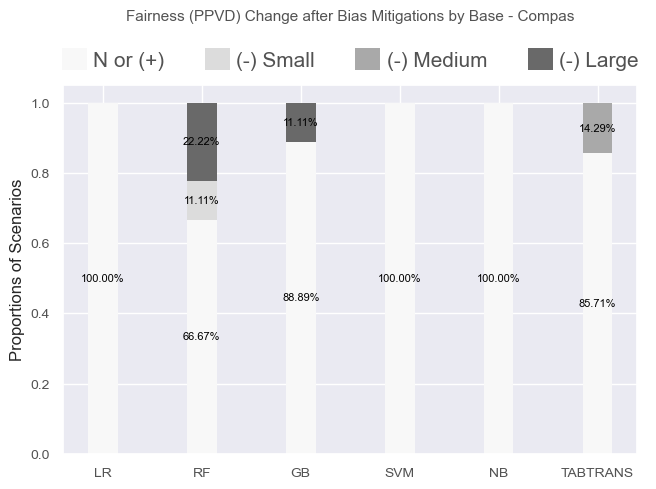

In [20]:
abs_avg_fairness_metrics = ['abs_'+ele for ele in avg_fairness_metrics]
diff_degree = behaviour_analysis(data=results_all_converted, metric_list=[FAIR_METRIC], category='base')
display(pd.DataFrame(diff_degree))
plot_behaviour_analysis(diff_degree, data_name, category='base', 
                        caption='Fairness (%s) Change after Bias Mitigations by Base - {}'%(FAIR_METRIC.split('_')[2].upper()),
                        figsize=(8, 6))

## Accuracy vs. Fairness

### General Results

(slope > 0: trade-off)
We can see from the graphs below:

1. Overall trend: the higher the accuracy, the lower the group fairness (positive slope)
2. But the choice of metrics does matter:
    - group fairness: ford_score showcased no "trade-offs"
    - accuracy metrics: f1_score and roc_auc_score showed milder "trade-offs"
    - same fairness metric combined with different accuracy metrics can present both positive/negative relations, vice versa

In [21]:
import matplotlib.pyplot as plt

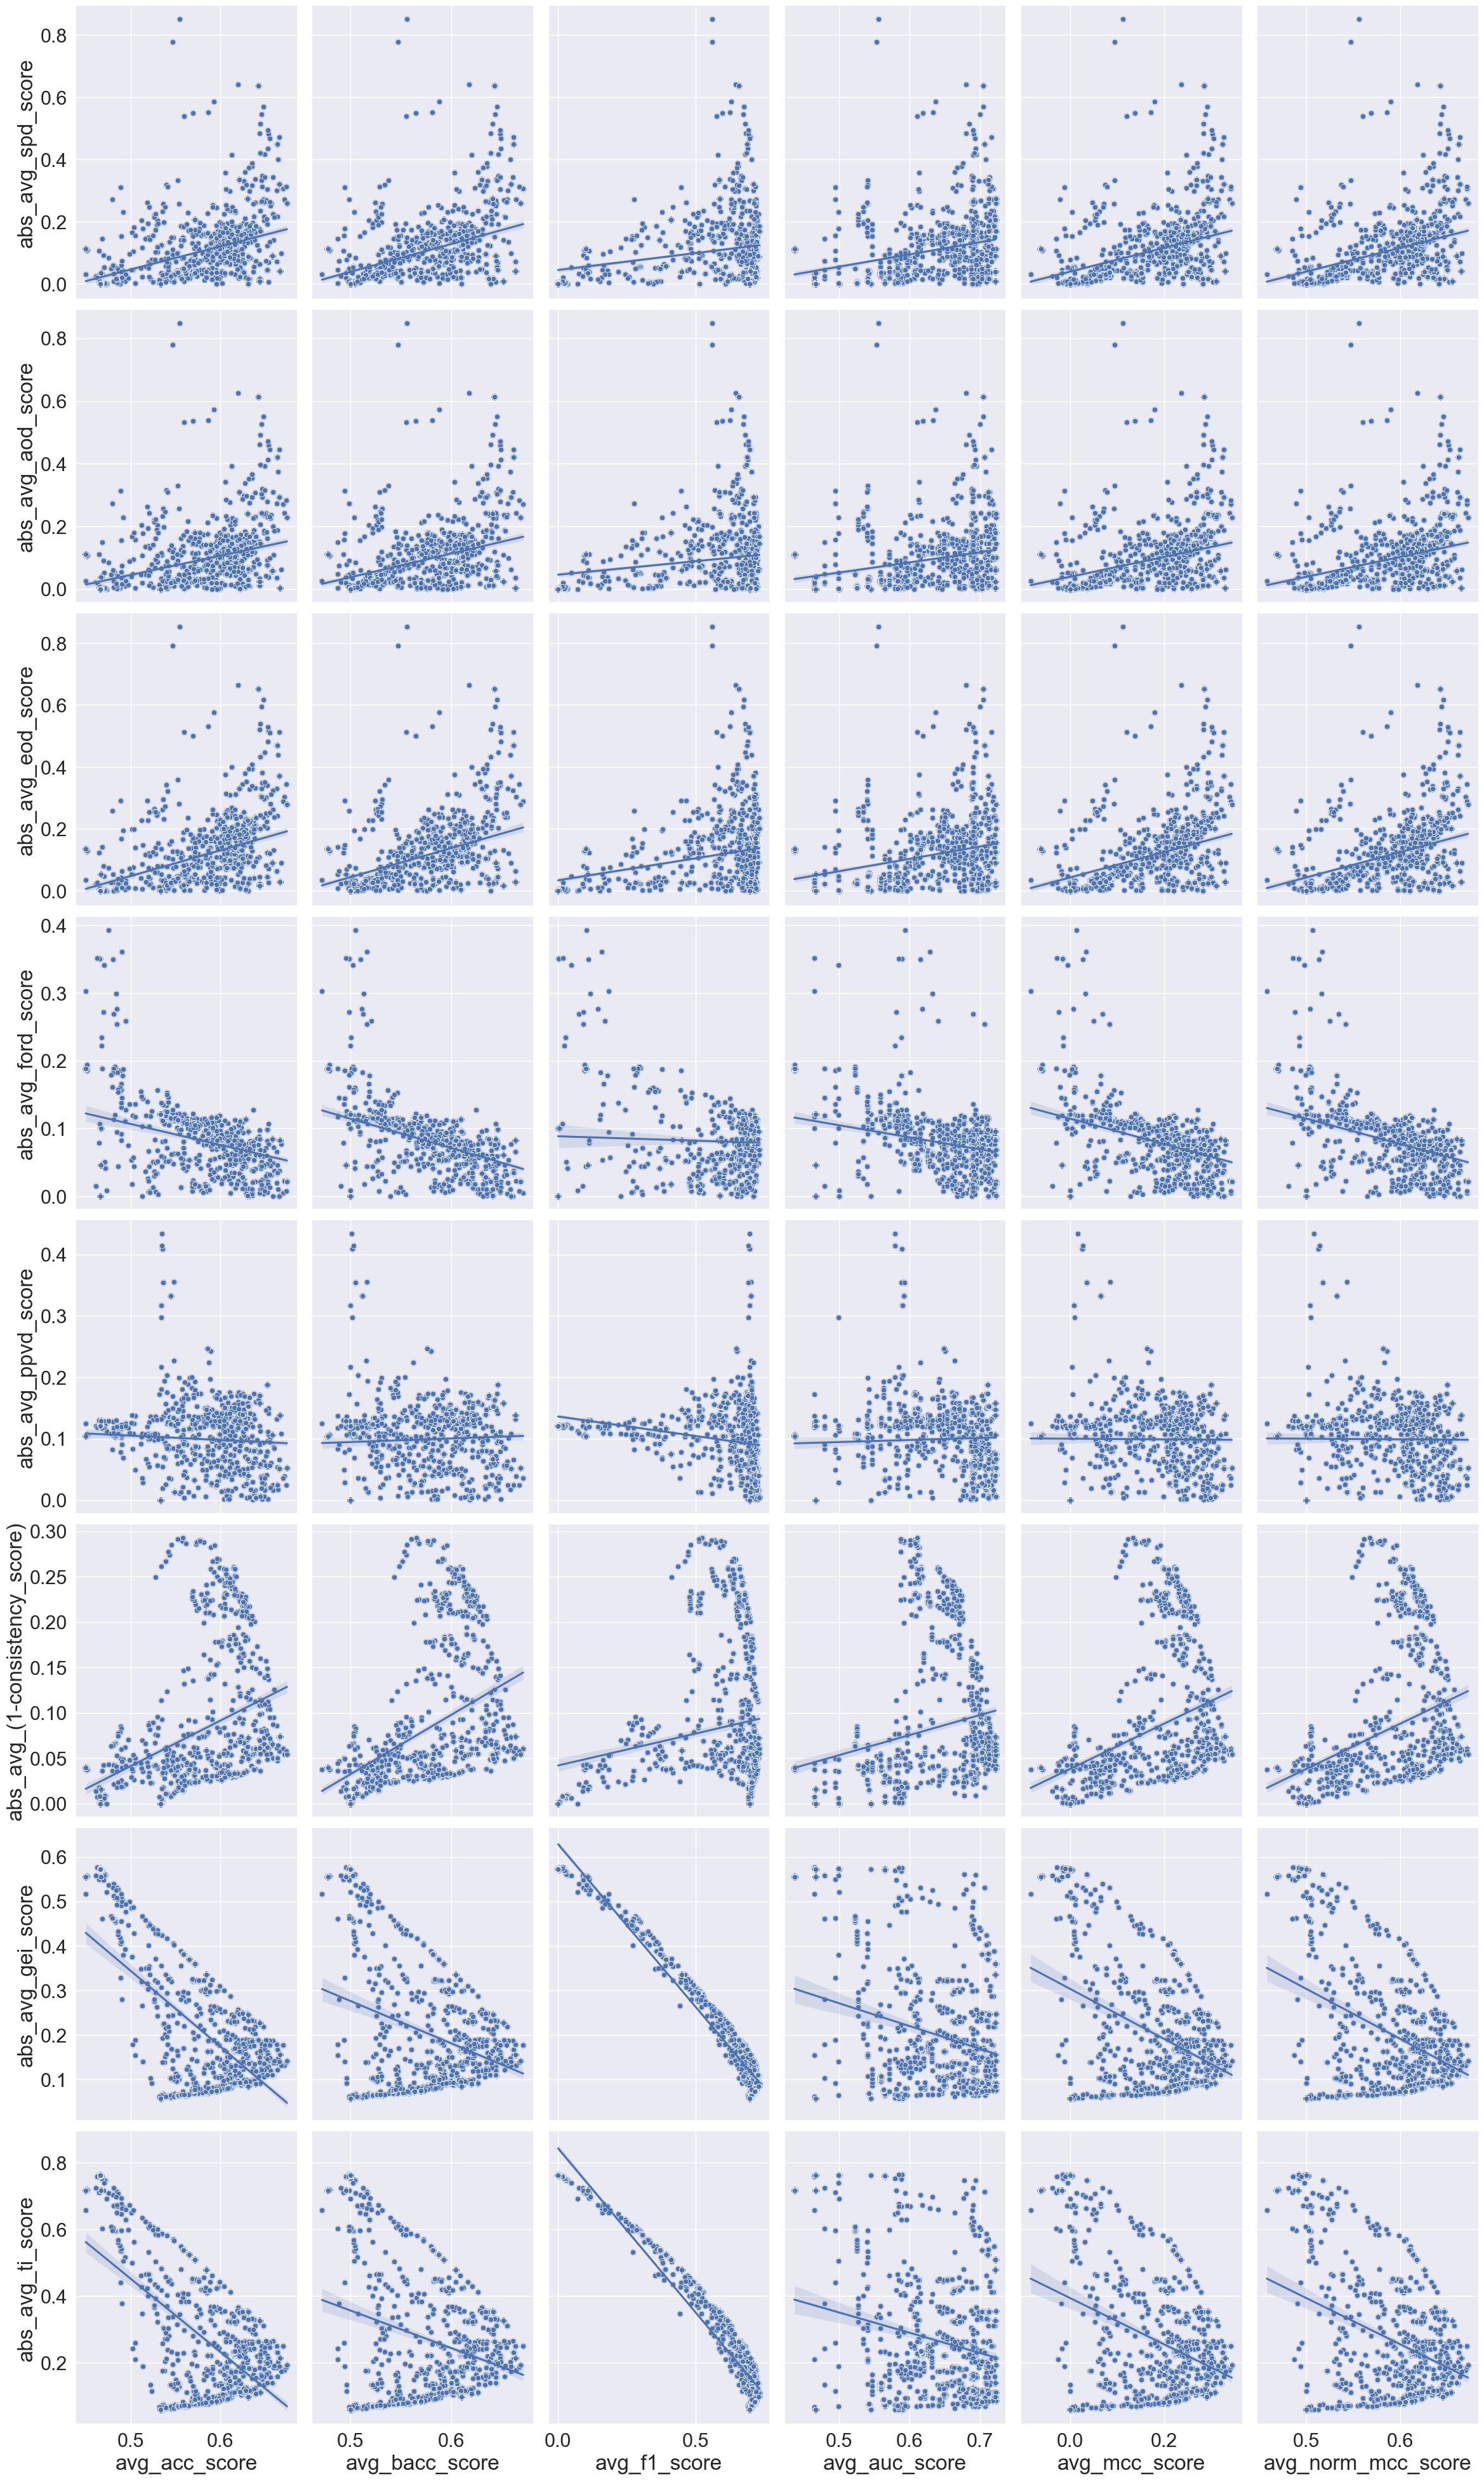

In [22]:
# Set plot font
plt.rcParams.update({'font.family':'serif'})
plt.rcParams.update({'font.serif':'Times New Roman'})

sns.set(font_scale = 2)
abs_fairness_metrics = ['abs_'+col for col in avg_fairness_metrics]
g = sns.pairplot(data=results_all_converted, x_vars=avg_accuracy_metrics, y_vars=abs_fairness_metrics,
             height=5, aspect=.8, kind="reg")
g.map(sns.scatterplot)

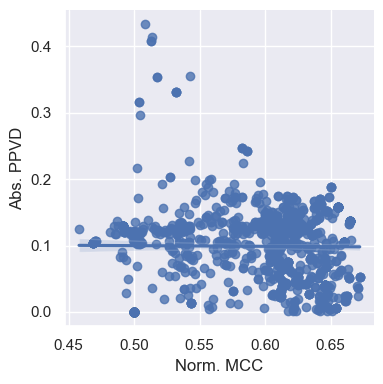

In [23]:
sns.set(font_scale = 1)
g = sns.lmplot(data=results_all_converted, x=ACC_METRIC, y=FAIR_METRIC, height=4)
# .fig.suptitle("Graph (a)")
ax = plt.gca()
ax.set(xlabel='Norm. MCC', ylabel='Abs. '+FAIR_METRIC.removeprefix('abs_').removeprefix('avg_').removesuffix('_score').upper())
# save plot
g.savefig('./Result_Plots/'+data_name+'_2D_general'+'.png', bbox_inches='tight')

### Base_estimator specific Results

We can see from the graphs below:
1. Different base_estimators can also generate very different results:
    - SVM (red) the least robust, while "NB" manifest clear trend
    - base_estimators divided into two groups when it comes to consistency_score: tree-based, ensemble (trade-offs) vs non tree-based, non ensemble

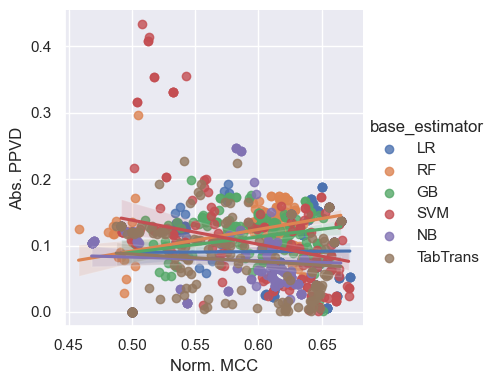

In [24]:
sns.set(font_scale = 1)
g = sns.lmplot(data=results_all_converted, x=ACC_METRIC, y=FAIR_METRIC, hue='base_estimator', 
               hue_order = ['LR','RF','GB','SVM','NB','TabTrans'], height=4)
ax = plt.gca()
ax.set(xlabel='Norm. MCC', ylabel='Abs. '+FAIR_METRIC.removeprefix('abs_').removeprefix('avg_').removesuffix('_score').upper())
# save plot
g.savefig('./Result_Plots/'+data_name+'_2D_Base'+'.png', bbox_inches='tight')

### Threshold specific Results

We can see from the graphs below:

1. Using different threshold also yiels different results:
    - most obvious with (f1_score, group_fairness) combinations

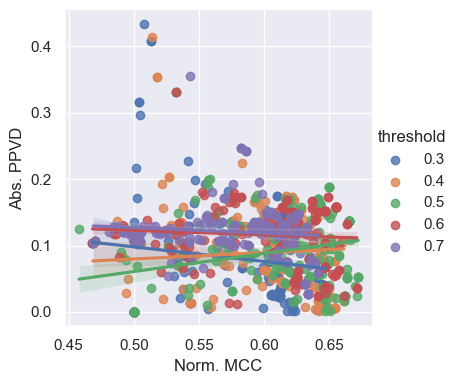

In [25]:
sns.set(font_scale = 1)
g = sns.lmplot(data=results_all_converted, x=ACC_METRIC, y=FAIR_METRIC, hue='threshold', height=4)
ax = plt.gca()
ax.set(xlabel='Norm. MCC', ylabel='Abs. '+FAIR_METRIC.removeprefix('abs_').removeprefix('avg_').removesuffix('_score').upper())
# save plot
g.savefig('./Result_Plots/'+data_name+'_2D_threshold'+'.png', bbox_inches='tight')

### Bias_mitigation specific Results

We can see from the graphs below:

1. Results are clearly divided into two groups
2. Generally with wide C.I.

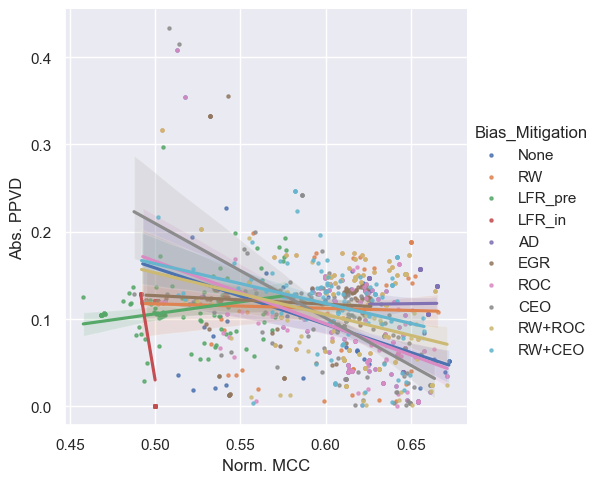

In [26]:
sns.set(font_scale = 1)
g = sns.lmplot(data=results_all_converted, x=ACC_METRIC, y=FAIR_METRIC, hue='Bias_Mitigation', 
               hue_order=['None','RW','LFR_pre','LFR_in','AD','EGR','ROC','CEO','RW+ROC','RW+CEO'],
               scatter_kws={'s': 5}, height=5)
ax = plt.gca()
ax.set(xlabel='Norm. MCC', ylabel='Abs. '+FAIR_METRIC.removeprefix('abs_').removeprefix('avg_').removesuffix('_score').upper())
# save plot
g.savefig('./Result_Plots/'+data_name+'_2D_BM'+'.png', bbox_inches='tight')

In [27]:
# sns.set(font_scale = 1)
# for base in results_all_converted.base_estimator.unique():
#     g = sns.lmplot(data=results_all_converted[results_all_converted.base_estimator==base],
#                    x=ACC_METRIC, y=FAIR_METRIC, hue="Bias_Mitigation", height=4).fig.suptitle(base)

### Bias Mitigation Category

In [28]:
bm_category = {'PRE':['RW', 'LFR_pre'],
               'IN': ['LFR_in','AD','EGR'],
               'POST':['ROC','CEO'],
               'PRE+POST':['RW+ROC','RW+CEO']}

In [29]:
results_all_converted['BM_Category'] = results_all_converted['Bias_Mitigation'].replace({v: k for k, l in bm_category.items()\
                                                                                         for v in l})
results_all_converted[['Bias_Mitigation','BM_Category']].drop_duplicates()

,Bias_Mitigation,BM_Category
0,None,None
5,RW,PRE
10,LFR_pre,PRE
15,EGR,IN
20,ROC,POST
25,CEO,POST
30,RW+ROC,PRE+POST
35,RW+CEO,PRE+POST
775,LFR_in,IN
780,AD,IN


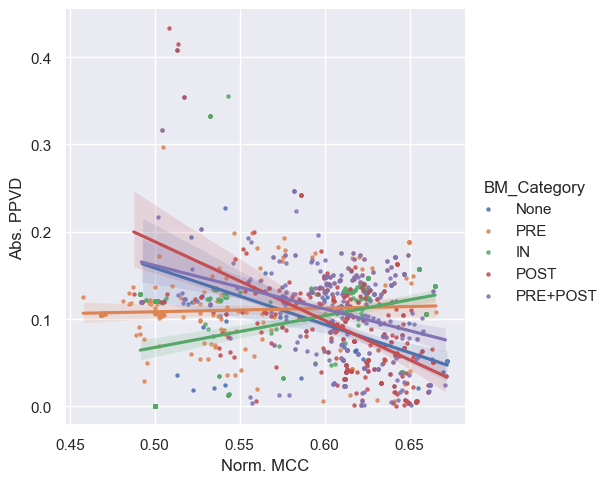

In [30]:
sns.set(font_scale = 1)
g = sns.lmplot(data=results_all_converted, x=ACC_METRIC, y=FAIR_METRIC, hue='BM_Category', 
               scatter_kws={'s': 5}, height=5)
ax = plt.gca()
ax.set(xlabel='Norm. MCC', ylabel='Abs. '+FAIR_METRIC.removeprefix('abs_').removeprefix('avg_').removesuffix('_score').upper())
# save plot
g.savefig('./Result_Plots/'+data_name+'_2D_BM_Category'+'.png', bbox_inches='tight')

In [31]:
# sns.set(font_scale = 1)
# for base in results_all_converted.base_estimator.unique():
#     g = sns.lmplot(data=results_all_converted[results_all_converted.base_estimator==base],
#                    x=ACC_METRIC, y=FAIR_METRIC, hue="BM_Category", height=4).fig.suptitle(base)

## Group vs. Individual Fairness

No clear trend between group and individual fairness with a few exceptions

In [32]:
# g = sns.pairplot(data=results_all_converted,
#                  x_vars=['abs_avg_'+col for col in group_fairness], y_vars=['abs_avg_'+col for col in individual_fairness],
#              height=5, aspect=.8, kind="reg")
# g.map(sns.scatterplot)

### Heatmap

<AxesSubplot:>

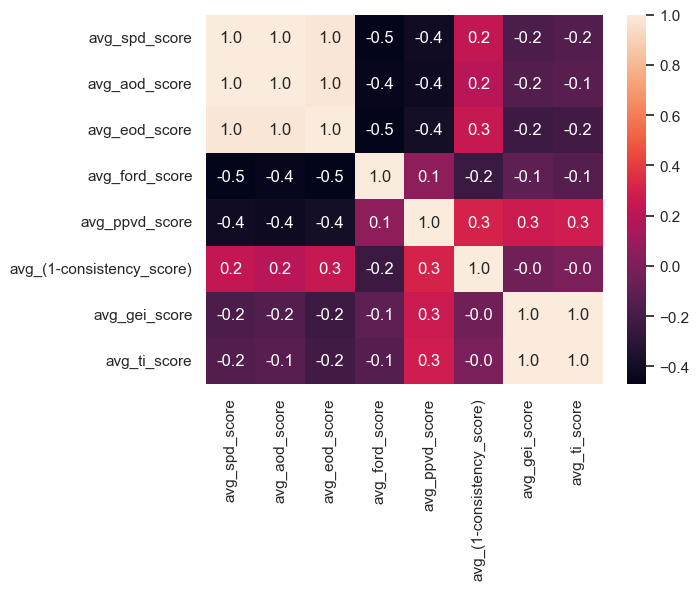

In [33]:
sns.set(font_scale = 1)
# avg_accuracy_metrics = ['avg_'+col for col in accuracy_metrics]
# avg_fairness_metrics = ['avg_'+col for col in fairness_metrics]
sns.heatmap(results_all_converted[avg_fairness_metrics].corr(), annot=True, fmt=".1f")

<AxesSubplot:>

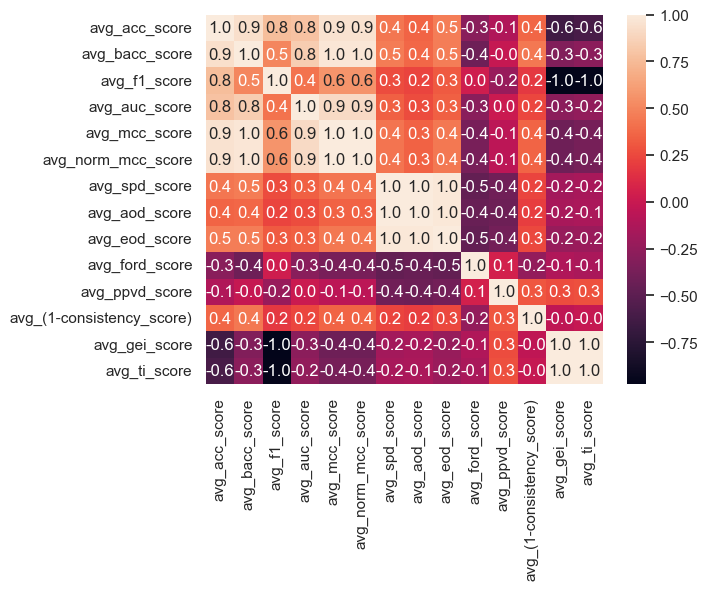

In [34]:
sns.set(font_scale = 1)
# avg_accuracy_metrics = ['avg_'+col for col in accuracy_metrics]
# avg_fairness_metrics = ['avg_'+col for col in fairness_metrics]
sns.heatmap(results_all_converted[avg_accuracy_metrics+avg_fairness_metrics].corr(), annot=True, fmt=".1f")